In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils.engine as ue
import utils.engine0d as ue0d
import utils.visualizer as uv

In [ ]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

In [ ]:
data = pd.read_csv('Validation/full_data.csv')

In [ ]:
data.columns

In [ ]:
with open("Validation/SHEBA_Data/12-levels.dat") as file:
    Z = [float(z.replace(' ', '')[:-1]) for z in file.readlines()]

## Вспомогательные функции

In [ ]:
def get_init_from_data(data, Z, dsigma_ice, dsigma_snow, snow_thickness_threshold=0.05, index=0):
    
    has_snow = (data.loc[index, 'hs_best'] - data.loc[index, 'hf_best']) >= snow_thickness_threshold
    
    filter_ice = (data.loc[index, 'hi_best'] < Z) & (Z < data.loc[index, 'hf_best'])
    filter_snow = (data.loc[index, 'hf_best'] < Z) & (Z < data.loc[index, 'hs_best'])

    Z_ice = np.concatenate((data.loc[index, ['hf_best']],
                            np.array(Z)[filter_ice],
                            data.loc[index, ['hi_best']]))

    Z_snow = np.concatenate((data.loc[index, ['hs_best']],
                            np.array(Z)[filter_snow],
                            data.loc[index, ['hf_best']]))

    T_ice = np.concatenate((data.loc[index, ['Tis_interp']],
                            data.loc[index, 'T_1':'T_50'][filter_ice],
                            data.loc[index, ['Tib_interp']]))

    T_snow = np.concatenate((data.loc[index, ['Tss']],
                             data.loc[index, 'T_1':'T_50'][filter_snow],
                             data.loc[index, ['Tis_interp']]))

    sigma_ice_nodes = np.concatenate(([0.0], dsigma_ice.cumsum()))
    sigma_ice_centers = (sigma_ice_nodes[:-1] + sigma_ice_nodes[1:])/2
    Z_ice_new = Z_ice[-1] + sigma_ice_centers*(Z_ice[0] - Z_ice[-1])

    sigma_snow_nodes = np.concatenate(([0.0], dsigma_snow.cumsum()))
    sigma_snow_centers = (sigma_snow_nodes[:-1] + sigma_snow_nodes[1:])/2
    Z_snow_new = Z_snow[-1] + sigma_snow_centers*(Z_snow[0] - Z_snow[-1])

    T_ice_new = np.interp(Z_ice_new, Z_ice[::-1], T_ice[::-1])
    T_snow_new = np.interp(Z_snow_new, Z_snow[::-1], T_snow[::-1])
    
    return T_ice_new, T_snow_new, \
            data.loc[index, 'Tib_interp'], data.loc[index, 'Tis_interp'], \
            (data.loc[index, 'Tss'] if has_snow else np.nan), \
            dsigma_ice*(data.loc[index, 'hf_best'] - data.loc[index, 'hi_best']), \
            (1.0 if has_snow else np.nan)*dsigma_snow \
            *(data.loc[index, 'hs_best'] - data.loc[index, 'hf_best'])

In [ ]:
def compare_profiles(process_data, process_simulation):
    assert process_data.get_length() == process_simulation.get_length(), \
           "Lenghts of input arrays ({}, {}) should be equal!".format(process_data.get_length(),
                                                                      process_simulation.get_length())
    
    assert process_data.get_nodes_num() == process_simulation.get_nodes_num(), \
           "Numbers of nodes for snow and ice for two processes ({}, {}) should be equal!"\
           .format(process_data.get_nodes_num(), process_simulation.get_nodes_num())
    
    plt.figure(figsize=(35, 50))
    
    plt.subplot(5, 2, 1)
    plt.title("Min temperarure error for ice")
    plt.plot(process_simulation.timeline,
             process_data.ice_temp_history.min(axis=1) - process_simulation.ice_temp_history.min(axis=1))
    plt.grid()
    
    plt.subplot(5, 2, 2)
    plt.title("Min temperarure error for snow")
    plt.plot(process_simulation.timeline,
             process_data.snow_temp_history.min(axis=1) - process_simulation.snow_temp_history.min(axis=1))
    plt.grid()
    
    plt.subplot(5, 2, 3)
    plt.title("Max temperarure error for ice")
    plt.plot(process_simulation.timeline,
             process_data.ice_temp_history.max(axis=1) - process_simulation.ice_temp_history.max(axis=1))
    plt.grid()
    
    plt.subplot(5, 2, 4)
    plt.title("Max temperarure error for snow")
    plt.plot(process_simulation.timeline,
             process_data.snow_temp_history.max(axis=1) - process_simulation.snow_temp_history.max(axis=1))
    plt.grid()
    
    plt.subplot(5, 2, 5)
    plt.title("Max temperature difference error for ice")
    plt.plot(process_simulation.timeline,
             abs(process_data.ice_temp_history - process_simulation.ice_temp_history).max(axis=1))
    plt.grid()
    
    plt.subplot(5, 2, 6)
    plt.title("Max temperarure difference error for snow")
    plt.plot(process_simulation.timeline,
             abs(process_data.snow_temp_history - process_simulation.snow_temp_history).max(axis=1))
    plt.grid()
    
    plt.subplot(5, 2, 7)
    plt.title("Avg temperature difference error for ice")
    plt.plot(process_simulation.timeline,
             np.sqrt(((process_data.ice_temp_history - process_simulation.ice_temp_history)**2).mean(axis=1)))
    plt.grid()
    
    plt.subplot(5, 2, 8)
    plt.title("Avg temperarure difference error for snow")
    plt.plot(process_simulation.timeline,
             np.sqrt(((process_data.snow_temp_history - process_simulation.snow_temp_history)**2).mean(axis=1)))
    plt.grid()
    
    plt.subplot(5, 2, 9)
    plt.title("Thickness error for ice")
    plt.plot(process_simulation.timeline,
             process_data.ice_dz_history.sum(axis=1) - process_simulation.ice_dz_history.sum(axis=1))
    plt.grid()
    
    plt.subplot(5, 2, 10)
    plt.title("Thickness error for snow")
    plt.plot(process_simulation.timeline,
             process_data.snow_dz_history.sum(axis=1) - process_simulation.snow_dz_history.sum(axis=1))
    plt.grid()
    
    plt.show()

In [ ]:
def plot_thicknesses(data_proc, sim_proc):
    plt.figure(figsize=(15, 10))
    plt.title('Ice thickness')
    plt.plot(sim_proc.ice_dz_history.sum(axis=1), label='simulation')
    plt.plot(data_proc.ice_dz_history.sum(axis=1), label='data')
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(15, 10))
    plt.title('Snow thickness')
    plt.plot(sim_proc.snow_dz_history.sum(axis=1), label='simulation')
    plt.plot(data_proc.snow_dz_history.sum(axis=1), label='data')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# timeline from file
time_arr = ((data['jday'] - data.loc[0, 'jday'])*24*3600).values

In [ ]:
# mesh thickening function
def thickening(N, s):
    if s == 0:
        return np.full(N, 1/N)
    else:
        return np.array([s*(1 - s)**i/(1 - (1 - s)**N) for i in range(N)])

In [ ]:
def plot_thickening(N, max_thick, step_thick):

    plt.figure(figsize=(10, 6))
    for s in np.arange(0, max_thick, step_thick):
        plt.plot([s]*(N+1), np.insert(np.cumsum(thickening(N, s)), 0,  0.0), marker='x', color='black')
    plt.xticks(np.arange(0, max_thick, step_thick))
    plt.xlabel('Level of thickening', size=20)
    plt.ylabel('Sigma-coordinate', size=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid()
    plt.grid(ls='--')
    plt.show()

## Форсинг

In [ ]:
# forcing
e_s = lambda T: 6.11*np.exp(ue.c1_i*T/(T + ue.T0 - ue.c2_i))
q_surf = lambda T: 0.622*e_s(T)/(ue.P_surf - 0.378*e_s(T))

albe = data['albe'].values
Tib_interp = data['Tib_interp'].values
tair = data['tair'].values
uair = data['uair'].values
qair = data['qair'].values
prec = data['prec_eff'].values
swdo = data['swdo'].values
lwdo = data['lwdo'].values
focn_pit = data['focn_pit'].values
Focn_y = data['Focn_y'].values


find_index_fast = lambda time_sec: np.searchsorted(time_arr, time_sec, side='right') - 1
albedo = lambda time: albe[find_index_fast(time)]
Toi = lambda time: Tib_interp[find_index_fast(time)]
T_a = lambda time: tair[find_index_fast(time)] - ue.T0
u_a = lambda time: uair[find_index_fast(time)]
q_a = lambda time: qair[find_index_fast(time)] * 1e-3
p = lambda time: prec[find_index_fast(time)] * ue.mmd_to_ms
F_sw = lambda time: swdo[find_index_fast(time)]
F_lw = lambda time: lwdo[find_index_fast(time)]
F_bolz = lambda T: -ue.sigma*(T + ue.T0)**4
F_sh = lambda T, time: ue.rho_a*ue.c_pa*ue.C_sh*u_a(time)*(T_a(time) - T)
F_lh = lambda T, time: ue.rho_a*ue.L_s0*ue.C_lh*u_a(time)*(q_a(time) - q_surf(T))
F_P = lambda T, time: p(time)*ue.rho_w*ue.c_pw*max(T_a(time) - T, 0)
F_atm = lambda T, time, i_0: ue.emissivity*(F_lw(time) + F_bolz(T)) \
                           + (1 - albedo(time))*(1 - i_0)*F_sw(time) \
                           + F_sh(T, time) + F_P(T, time) + F_lh(T, time) 

F_atm_ice = lambda T, time: F_atm(T, time, ue.i0_i)
F_atm_snow = lambda T, time: F_atm(T, time, ue.i0_s)
F_ocn = lambda T, time: Focn_y[find_index_fast(time)]

# Эксперименты на регулярной сетке

In [ ]:
# regular mesh
dsigma_ice_n4s0 = thickening(4, 0.0)
dsigma_ice_n8s0 = thickening(8, 0.0)
dsigma_ice_n16s0 = thickening(16, 0.0)
dsigma_ice_n32s0 = thickening(32, 0.0)
dsigma_ice_n64s0 = thickening(64, 0.0)
dsigma_snow_n10s0 = thickening(10, 0.0)

In [ ]:
# init state from data
T_ice_init4, T_snow_init4, Toi_init4, Tis_init4, Tsa_init4, \
dzi_init4, dzs_init4 = get_init_from_data(data, Z, dsigma_ice_n4s0, dsigma_snow_n10s0)

T_ice_init8, T_snow_init8, Toi_init8, Tis_init8, Tsa_init8, \
dzi_init8, dzs_init8 = get_init_from_data(data, Z, dsigma_ice_n8s0, dsigma_snow_n10s0)

T_ice_init16, T_snow_init16, Toi_init16, Tis_init16, Tsa_init16, \
dzi_init16, dzs_init16 = get_init_from_data(data, Z, dsigma_ice_n16s0, dsigma_snow_n10s0)

T_ice_init32, T_snow_init32, Toi_init32, Tis_init32, Tsa_init32, \
dzi_init32, dzs_init32 = get_init_from_data(data, Z, dsigma_ice_n32s0, dsigma_snow_n10s0)

T_ice_init64, T_snow_init64, Toi_init64, Tis_init64, Tsa_init64, \
dzi_init64, dzs_init64 = get_init_from_data(data, Z, dsigma_ice_n64s0, dsigma_snow_n10s0)

In [ ]:
# process from data
data_proc_ni4s0ns10s0 = ue.process_from_data(Z,
                                 data.loc[:, 'T_1':'T_50'].values, 
                                 data['Tib_interp'].values, data['Tis_interp'].values,
                                 data['Tss'].values,
                                 data['hi_best'].values, data['hf_best'].values,
                                 data['hs_best'].values,
                                 dsigma_ice_n4s0, dsigma_snow_n10s0,
                                 time_arr, ue.rho_i)

data_proc_ni8s0ns10s0 = ue.process_from_data(Z,
                                 data.loc[:, 'T_1':'T_50'].values, 
                                 data['Tib_interp'].values, data['Tis_interp'].values,
                                 data['Tss'].values,
                                 data['hi_best'].values, data['hf_best'].values,
                                 data['hs_best'].values,
                                 dsigma_ice_n8s0, dsigma_snow_n10s0,
                                 time_arr, ue.rho_i)

data_proc_ni16s0ns10s0 = ue.process_from_data(Z,
                                 data.loc[:, 'T_1':'T_50'].values, 
                                 data['Tib_interp'].values, data['Tis_interp'].values,
                                 data['Tss'].values,
                                 data['hi_best'].values, data['hf_best'].values,
                                 data['hs_best'].values,
                                 dsigma_ice_n16s0, dsigma_snow_n10s0,
                                 time_arr, ue.rho_i)

data_proc_ni32s0ns10s0 = ue.process_from_data(Z,
                                 data.loc[:, 'T_1':'T_50'].values, 
                                 data['Tib_interp'].values, data['Tis_interp'].values,
                                 data['Tss'].values,
                                 data['hi_best'].values, data['hf_best'].values,
                                 data['hs_best'].values,
                                 dsigma_ice_n32s0, dsigma_snow_n10s0,
                                 time_arr, ue.rho_i)

data_proc_ni64s0ns10s0 = ue.process_from_data(Z,
                                 data.loc[:, 'T_1':'T_50'].values, 
                                 data['Tib_interp'].values, data['Tis_interp'].values,
                                 data['Tss'].values,
                                 data['hi_best'].values, data['hf_best'].values,
                                 data['hs_best'].values,
                                 dsigma_ice_n64s0, dsigma_snow_n10s0,
                                 time_arr, ue.rho_i)

In [ ]:
%%time
sim_proc_0d = ue0d.main_process_0d \
(
    time_step=3600.0,
    time_end=7774*3600.0,
    N_pseudoiter=50,
    Tis_init=data.loc[0, 'Tis_interp'],
    Tsa_init=data.loc[0, 'Tss'],
    ice_thickness_init=data.loc[0, 'hf_best'] - data.loc[0, 'hi_best'],
    snow_thickness_init=data.loc[0, 'hs_best'] - data.loc[0, 'hf_best'],
    snow_thickness_threshold=0.01,
    Toi=Toi,
    Ta=T_a,
    p=p,
    F_atm_ice=F_atm_ice,
    F_atm_snow=F_atm_snow,
    F_ocn=F_ocn
)

In [ ]:
%%time
sim_proc_ni4s0ns10s0 = ue.main_process \
(
    time_step=3600.0,
    time_end=7774*3600.0,
    N_pseudoiter=50,
    Ti_init=T_ice_init4,
    Ts_init=T_snow_init4,
    Tis_init=Tis_init4,
    Tsa_init=Tsa_init4,
    dzi_init=dzi_init4,
    dzs_init=dzs_init4,
    salinity=np.linspace(4.0, 1.0, len(dzi_init4)),
    snow_thickness_threshold=0.01,
    Toi=Toi,
    Ta=T_a,
    p=p,
    F_atm_ice=F_atm_ice,
    F_atm_snow=F_atm_snow,
    F_sw=F_sw,
    F_ocn=F_ocn
)

In [ ]:
%%time
sim_proc_ni8s0ns10s0 = ue.main_process \
(
    time_step=3600.0,
    time_end=7774*3600.0,
    N_pseudoiter=50,
    Ti_init=T_ice_init8,
    Ts_init=T_snow_init8,
    Tis_init=Tis_init8,
    Tsa_init=Tsa_init8,
    dzi_init=dzi_init8,
    dzs_init=dzs_init8,
    salinity=np.linspace(4.0, 1.0, len(dzi_init8)),
    snow_thickness_threshold=0.01,
    Toi=Toi,
    Ta=T_a,
    p=p,
    F_atm_ice=F_atm_ice,
    F_atm_snow=F_atm_snow,
    F_sw=F_sw,
    F_ocn=F_ocn
)

In [ ]:
%%time
sim_proc_ni16s0ns10s0 = ue.main_process \
(
    time_step=3600.0,
    time_end=7774*3600.0,
    N_pseudoiter=50,
    Ti_init=T_ice_init16,
    Ts_init=T_snow_init16,
    Tis_init=Tis_init16,
    Tsa_init=Tsa_init16,
    dzi_init=dzi_init16,
    dzs_init=dzs_init16,
    salinity=np.linspace(4.0, 1.0, len(dzi_init16)),
    snow_thickness_threshold=0.01,
    Toi=Toi,
    Ta=T_a,
    p=p,
    F_atm_ice=F_atm_ice,
    F_atm_snow=F_atm_snow,
    F_sw=F_sw,
    F_ocn=F_ocn
)

In [ ]:
%%time
sim_proc_ni32s0ns10s0 = ue.main_process \
(
    time_step=3600.0,
    time_end=7774*3600.0,
    N_pseudoiter=50,
    Ti_init=T_ice_init32,
    Ts_init=T_snow_init32,
    Tis_init=Tis_init32,
    Tsa_init=Tsa_init32,
    dzi_init=dzi_init32,
    dzs_init=dzs_init32,
    salinity=np.linspace(4.0, 1.0, len(dzi_init32)),
    snow_thickness_threshold=0.01,
    Toi=Toi,
    Ta=T_a,
    p=p,
    F_atm_ice=F_atm_ice,
    F_atm_snow=F_atm_snow,
    F_sw=F_sw,
    F_ocn=F_ocn
)

In [ ]:
%%time
sim_proc_ni64s0ns10s0 = ue.main_process \
(
    time_step=3600.0,
    time_end=7774*3600.0,
    N_pseudoiter=50,
    Ti_init=T_ice_init64,
    Ts_init=T_snow_init64,
    Tis_init=Tis_init64,
    Tsa_init=Tsa_init64,
    dzi_init=dzi_init64,
    dzs_init=dzs_init64,
    salinity=np.linspace(4.0, 1.0, len(dzi_init64)),
    snow_thickness_threshold=0.01,
    Toi=Toi,
    Ta=T_a,
    p=p,
    F_atm_ice=F_atm_ice,
    F_atm_snow=F_atm_snow,
    F_sw=F_sw,
    F_ocn=F_ocn
)

In [ ]:
uv.timeseries_err(sim_proc_ni4s0ns10s0[1000:3000],
                  data_proc_ni4s0ns10s0[1000:3000],
                  tmin_err=-4., tmax_err=4.,step_err=.2, 
                  figsize=(20, 10))

In [ ]:
uv.timeseries_err(sim_proc_ni8s0ns10s0[1000:3000],
                  data_proc_ni8s0ns10s0[1000:3000],
                  tmin_err=-4., tmax_err=4., step_err=.2,
                  figsize=(20, 10))

In [ ]:
uv.timeseries_err(sim_proc_ni16s0ns10s0[1000:3000],
                  data_proc_ni16s0ns10s0[1000:3000],
                  tmin_err=-4., tmax_err=4., step_err=.2,
                  figsize=(20, 10))

In [ ]:
uv.timeseries_err(sim_proc_ni32s0ns10s0[1000:3000],
                  data_proc_ni32s0ns10s0[1000:3000],
                  tmin_err=-4., tmax_err=4., step_err=.2,
                  figsize=(20, 10))

In [ ]:
uv.timeseries_err(sim_proc_ni64s0ns10s0, data_proc_ni64s0ns10s0, tmin_err=-4., tmax_err=4., step_err=.5)

## Эксперименты на сгущенной сетке (Ni = 4)

In [ ]:
plot_thickening(N=4, max_thick=0.41, step_thick=0.05)

In [ ]:
# thickened mesh
dsigma_ice_n4s20 = thickening(4, 0.2)
dsigma_ice_n4s35 = thickening(4, 0.35)

dsigma_snow_n10s0 = thickening(15, 0.0)

In [ ]:
# init state from data
T_ice_init4_s20, T_snow_init4_s20, Toi_init4_s20, Tis_init4_s20, Tsa_init4_s20, \
dzi_init4_s20, dzs_init4_s20 = get_init_from_data(data, Z, dsigma_ice_n4s20, dsigma_snow_n10s0)

T_ice_init4_s35, T_snow_init4_s35, Toi_init4_s35, Tis_init4_s35, Tsa_init4_s35, \
dzi_init4_s35, dzs_init4_s35 = get_init_from_data(data, Z, dsigma_ice_n4s35, dsigma_snow_n10s0)

In [ ]:
# process from data
data_proc_ni4s20ns10s0 = ue.process_from_data(Z,
                                 data.loc[:, 'T_1':'T_50'].values, 
                                 data['Tib_interp'].values, data['Tis_interp'].values,
                                 data['Tss'].values,
                                 data['hi_best'].values, data['hf_best'].values,
                                 data['hs_best'].values,
                                 dsigma_ice_n4s20, dsigma_snow_n10s0,
                                 time_arr, ue.rho_i)

data_proc_ni4s35ns10s0 = ue.process_from_data(Z,
                                 data.loc[:, 'T_1':'T_50'].values, 
                                 data['Tib_interp'].values, data['Tis_interp'].values,
                                 data['Tss'].values,
                                 data['hi_best'].values, data['hf_best'].values,
                                 data['hs_best'].values,
                                 dsigma_ice_n4s35, dsigma_snow_n10s0,
                                 time_arr, ue.rho_i)

In [ ]:
%%time
sim_proc_ni4s20ns10s0 = ue.main_process \
(
    time_step=3600.0,
    time_end=7774*3600.0,
    N_pseudoiter=50,
    Ti_init=T_ice_init4_s20,
    Ts_init=T_snow_init4_s20,
    Tis_init=Tis_init4_s20,
    Tsa_init=Tsa_init4_s20,
    dzi_init=dzi_init4_s20,
    dzs_init=dzs_init4_s20,
    salinity=np.linspace(4.0, 1.0, len(dzi_init4_s20)),
    snow_thickness_threshold=0.01,
    Toi=Toi,
    Ta=T_a,
    p=p,
    F_atm_ice=F_atm_ice,
    F_atm_snow=F_atm_snow,
    F_sw=F_sw,
    F_ocn=F_ocn
)

In [ ]:
%%time
sim_proc_ni4s35ns10s0 = ue.main_process \
(
    time_step=3600.0,
    time_end=7774*3600.0,
    N_pseudoiter=50,
    Ti_init=T_ice_init4_s35,
    Ts_init=T_snow_init4_s35,
    Tis_init=Tis_init4_s35,
    Tsa_init=Tsa_init4_s35,
    dzi_init=dzi_init4_s35,
    dzs_init=dzs_init4_s35,
    salinity=np.linspace(4.0, 1.0, len(dzi_init4_s35)),
    snow_thickness_threshold=0.01,
    Toi=Toi,
    Ta=T_a,
    p=p,
    F_atm_ice=F_atm_ice,
    F_atm_snow=F_atm_snow,
    F_sw=F_sw,
    F_ocn=F_ocn
)

In [ ]:
uv.timeseries_err(sim_proc_ni4s20ns10s0[1000:3000],
                  data_proc_ni4s20ns10s0[1000:3000],
                  tmin_err=-4., tmax_err=4., step_err=.2,
                  figsize=(20, 10))

In [ ]:
uv.timeseries_err(sim_proc_ni4s35ns10s0[1000:3000],
                  data_proc_ni4s35ns10s0[1000:3000],
                  tmin_err=-4., tmax_err=4., step_err=.2,
                  figsize=(20,10))

## Эксперименты на сгущенной сетке (Ni = 16)

In [ ]:
plot_thickening(N=8, max_thick=0.41, step_thick=0.05)

In [ ]:
# thickened mesh
dsigma_ice_n16t = np.concatenate((thickening(4, 0.0)/2.0, thickening(12, 0.0)/2))


In [ ]:
# init state from data
T_ice_init_n16t, T_snow_init_n16t, Toi_init_n16t, Tis_init_n16t, Tsa_init_n16t, \
dzi_init_n16t, dzs_init_n16t = get_init_from_data(data, Z, dsigma_ice_n16t, dsigma_snow_n10s0)

In [ ]:
# process from data
data_proc_ni16tns10s0 = ue.process_from_data(Z,
                                 data.loc[:, 'T_1':'T_50'].values, 
                                 data['Tib_interp'].values, data['Tis_interp'].values,
                                 data['Tss'].values,
                                 data['hi_best'].values, data['hf_best'].values,
                                 data['hs_best'].values,
                                 dsigma_ice_n16t, dsigma_snow_n10s0,
                                 time_arr, ue.rho_i)

In [ ]:
%%time
sim_proc_ni4s35ns10s0 = ue.main_process \
(
    time_step=3600.0,
    time_end=7774*3600.0,
    N_pseudoiter=50,
    Ti_init=T_ice_init_n16t,
    Ts_init=T_snow_init_n16t,
    Tis_init=Tis_init_n16t,
    Tsa_init=Tsa_init_n16t,
    dzi_init=dzi_init_n16t,
    dzs_init=dzs_init_n16t,
    salinity=np.linspace(4.0, 1.0, len(dzi_init_n16t)),
    snow_thickness_threshold=0.01,
    Toi=Toi,
    Ta=T_a,
    p=p,
    F_atm_ice=F_atm_ice,
    F_atm_snow=F_atm_snow,
    F_sw=F_sw,
    F_ocn=F_ocn
)

In [ ]:
uv.timeseries_err(sim_proc_ni4s35ns10s0[1000:3000],
                  data_proc_ni16tns10s0[1000:3000],
                  tmin_err=-4., tmax_err=4., step_err=.2,
                  figsize=(20,10))

In [ ]:
uv.timeseries_err(sim_proc_0d,
                  data_proc_ni64s0ns10s0,
                  levels_border=[],
                  tmin_err=-4., tmax_err=4., step_err=1,
                  figsize=(20, 10))

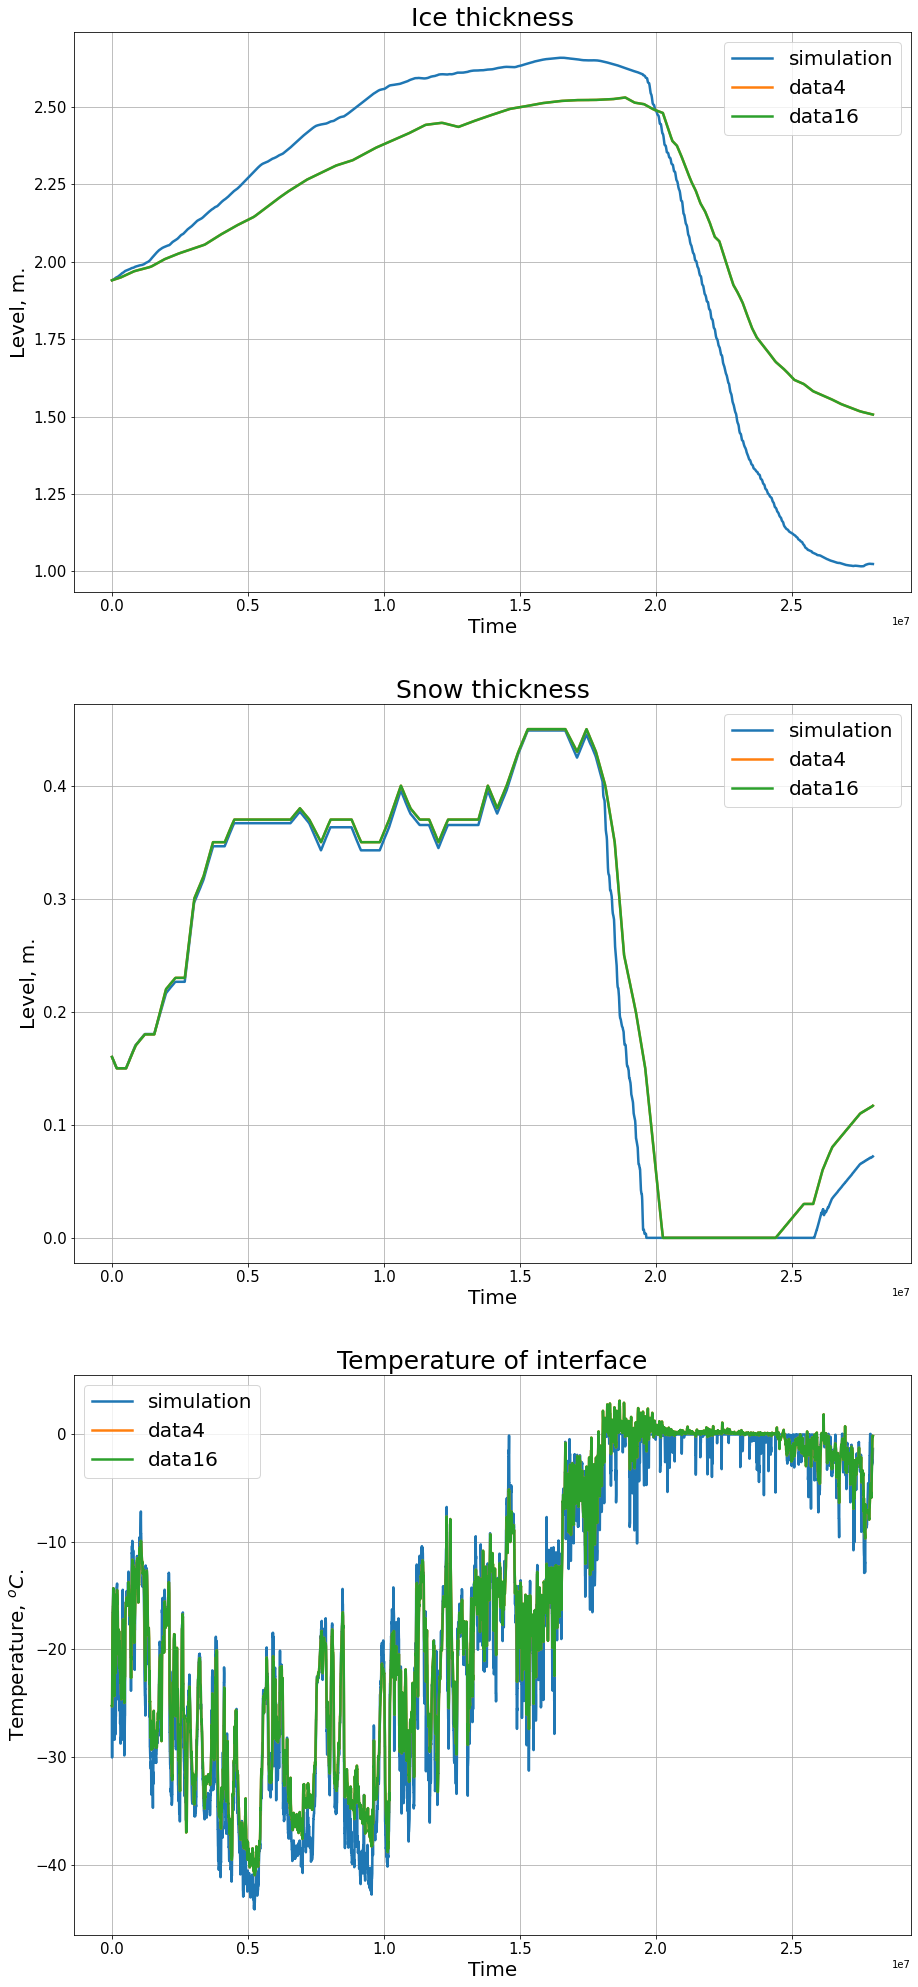

In [85]:
plot_characteristics([sim_proc_0d, data_proc_ni4s0ns10s0, data_proc_ni16s0ns10s0],
                     ['simulation', 'data4', 'data16'])